В файле $outs$ пишется куча запусков за день, каждый запуск длится 2 минуты, за это время считывается около 10000 событий. Формат:

Кол-во сработавших кластеров

N кластера   N события   время (чч:мм:сс,мс.мкс.нс)

AB0  TB0  AM0  TM0  AB1  TB1  AM1  TM1  AB2  TB2  AM2  TM2  AB3  TB3  AM3  TM3

AB0  TB0  AM0  TM0  AB1  TB1  AM1  TM1  AB2  TB2  AM2  TM2  AB3  TB3  AM3  TM3

AB0  TB0  AM0  TM0  AB1  TB1  AM1  TM1  AB2  TB2  AM2  TM2  AB3  TB3  AM3  TM3

AB0  TB0  AM0  TM0  AB1  TB1  AM1  TM1  AB2  TB2  AM2  TM2  AB3  TB3  AM3  TM3

AB0  TB0  AM0  TM0  AB1  TB1  AM1  TM1  AB2  TB2  AM2  TM2  AB3  TB3  AM3  TM3

AB0  TB0  AM0  TM0  AB1  TB1  AM1  TM1  AB2  TB2  AM2  TM2  AB3  TB3  AM3  TM3

AB0  TB0  AM0  TM0  AB1  TB1  AM1  TM1  AB2  TB2  AM2  TM2  AB3  TB3  AM3  TM3

AB28  TB28  AM28  TM28  AB29  TB29  AM29  TM29  AB30  TB30  AM30  TM30  AB31  TB31  AM31  TM31

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import gc
from matplotlib.patches import RegularPolygon #drawing hexagons
#import shapely #to attribute geometric properties for shapes
#from shapely.geometry import Polygon
#from matplotlib.patches import RegularPolygon

NameError: name 'Polygon' is not defined

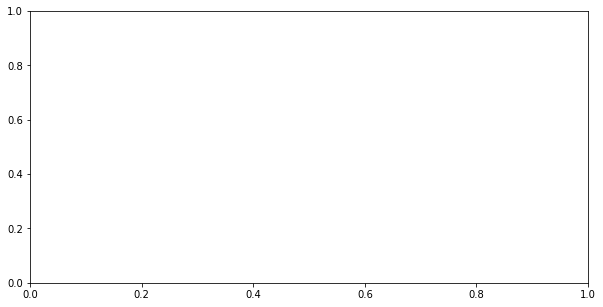

In [39]:


fig, ax = plt.subplots(figsize=(10,5))
xmin, xmax = 0, 20
ymin, ymax = 0, 10
n_cols=15
n_rows=25
w = (xmax-xmin)/n_cols # width of hexagon
d = w/np.sin(np.pi/3) #diameter of hexagon
array_of_hexes = []
for rows in range(0,n_rows):
    hcoord = np.arange(xmin,xmax,w) + (rows%2)*w/2
    vcoord = [ymax- rows*d*0.75]*n_cols
    for x, y in zip(hcoord, vcoord):#, colors):
        hexes = RegularPolygon((x, y), numVertices=6, radius=d/2, alpha=0.1, edgecolor='k')
        verts = hexes.get_path().vertices
        trans = hexes.get_patch_transform()
        points = trans.transform(verts)
        array_of_hexes.append(Polygon(points))
        ax.add_patch(hexes)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

In [ ]:
#когда-нибудь здесь будет класс для события

In [2]:
Nrun = '{:03}'.format(10)
COLORS = np.array(['r', 'y', 'g', 'c', 'b', 'm', 'k'])

In [3]:
def Peds(Nrun):
    pathped = "./231119.01/peds/231119.ped_"
    peds = [[0 for i in range(64)] for j in range(24)] #здесь хранятся данные по пьедесталам 
                           #каждого канала по данному рану
    pedsfile = open(pathped+Nrun, "r")
    while True:  
        line = pedsfile.readline().split()
        if not line:
            break
        peds[int(line[0]) - 1][int(line[1])] = round(float(line[2])) #кластеры индексируются с 1, каналы с 0, 
                                                              #пьедестал округляю
    pedsfile.close()
    return peds
peds = Peds(Nrun)

In [42]:
def dist(c1, c2):
    return np.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)

class Event():
    def __init__(self, Nevent = 0, eventtime = "12:34:56,789.101.112", clusters = None):
        if clusters is None:
            clusters = []
        self.clusters = dict()
        for cluster in clusters:
            self.clusters[cluster[0]] = cluster[1]
        self.Nclusters = len(clusters)
        self.Nevent = '{:06}'.format(Nevent)
        self.time = eventtime
        self.size = 0
        self.vmax = 0
        self.pixels = None
        
        self.xm = None
        self.ym = None
        self.x2m = None
        self.y2m = None
        self.xym = None
        self.Hillas = {"a": None, "b": None, "width": None, "length": None, "dis": None, "miss": None}
        
    def __str__(self):
        return "#"+self.Nevent+'  '+self.time
    def __repr__(self):
        return "#"+self.Nevent+'  '+self.time
    def __len__(self):
        return len(self.pixels)
    
    def recount(self, factors, coords):
        self.pixels = dict()
        
        for cluster in self.clusters:
            #print(self.clusters[cluster])
            for channel in range(64):
                if self.clusters[cluster][channel][0] > 0:
                    x = coords[cluster - 1][channel][0]
                    y = coords[cluster - 1][channel][1]
                    n = coords[cluster - 1][channel][2]
                    if factors[cluster][channel] is not None:
                        v = int(round(self.clusters[cluster][channel][0] / factors[cluster][channel]))
                    else:
                        v = None
                    
                    if x is not None and y is not None and v is not None:
                        self.pixels[n]=(x, y, v)
                        self.size += v
                        
                        if v > self.vmax: self.vmax = v

        return self
    
    def params(self):
        if None in self.Hillas.values() and self.size > 0:
            self.xm, self.ym, self.x2m, self.y2m, self.xym = 0, 0, 0, 0, 0
            xsum, x2sum, ysum, y2sum, xysum = 0, 0, 0, 0, 0
            for pixel in self.pixels:
                x, y, v = self.pixels[pixel]
                xsum += x * v
                x2sum += x * x * v
                ysum += y * v
                y2sum += y * y * v
                xysum += x * y * v
            self.xm = xsum / self.size
            self.ym = ysum / self.size
            self.x2m = x2sum / self.size
            self.y2m = y2sum / self.size
            self.xym = xysum / self.size
            sigmax = self.x2m - self.xm**2
            sigmay = self.y2m - self.ym**2
            sigmaxy = self.xym - self.xm*self.ym
            d = sigmay-sigmax

            a = self.Hillas["a"] = (d+np.sqrt(d*d+4*sigmaxy**2))/(2*sigmaxy)
            b = self.Hillas["b"] = self.ym-self.Hillas["a"]*self.xm
            self.Hillas["width"] = np.sqrt((sigmay-2*a*sigmaxy+a*a*sigmax)/(1+a*a))
            self.Hillas["length"] = np.sqrt((sigmax+2*a*sigmaxy+a*a*sigmay)/(1+a*a))
            self.Hillas["dis"] = np.sqrt(self.xm**2+self.ym**2)
            self.Hillas["miss"] = abs(b/np.sqrt(1+a*a))
            self.Hillas["size"] = self.size
            self.Hillas["coords"] = (self.xm, self.ym)
            return self.Hillas
        elif self.size == 0:
            return False
        else:
            return self.Hillas
    def vizualize(self, colors = COLORS, alpha = 0.3, pixel_coords = None, save = False):
        #alpha = 0.3 #параметр для нормирования прозрачности
        fig, ax = plt.subplots(figsize=(7,7))
        ax.set_title("#"+self.Nevent+"   "+str(self.time), fontsize=16)
        ax.set_xlim([-40, 40])
        ax.set_ylim([-40, 40])
        
        if pixel_coords is not None:
            for pixel in pixel_coords:
                if pixel not in self.pixels:
                    plt.scatter(pixel_coords[pixel][1], pixel_coords[pixel][2], color = colors[(pixel_coords[pixel][0]-1)%7], alpha = 0.1)
                else:
                    plt.scatter(pixel_coords[pixel][1], pixel_coords[pixel][2], color = "orange", alpha = alpha + (1-alpha)*self.pixels[pixel][2]/self.vmax)
                    ax.text(self.pixels[pixel][0], self.pixels[pixel][1], str(self.pixels[pixel][2]), fontsize = 10) 
        else:    
            for pixel in self.pixels:
                plt.scatter(self.pixels[pixel][0], self.pixels[pixel][1], color = "orange", alpha = alpha + (1-alpha)*self.pixels[pixel][2]/self.vmax)
                ax.text(self.pixels[pixel][0], self.pixels[pixel][1], str(self.pixels[pixel][2]), fontsize = 10) 
        if save:
            plt.savefig("results/"+self.Nevent+".png", dpi = 200)
    
    def clean(self, A = 14, B = 7):
        b = deepcopy(self)
        b.size = 0
        for pixel in self.pixels:
            if self.pixels[pixel][2] < A:
                b.pixels.pop(pixel)
            else:
                n = False
                for pixel1 in self.pixels:
                    if dist(self.pixels[pixel], self.pixels[pixel1]) < 3.1 and self.pixels[pixel][2] > B:
                        n = True
                        b.size += b.pixels[pixel][2]
                        break
                if not n: b.pixels.pop(pixel)
        del self.clusters
        self.clusters = []    #убираем мусор
        #if len(b.pixels): b.params()        
        return b
c = [(17, [[4, 0], [0, 0], [0, 0], [0, 0], [1, 0], [0, 1], [149, 0], [26, 0], [0, 0], [2, 0], [0, 0], [0, 0], [3, 0], [4, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 0], [0, 0], [0, 0], [0, 0], [0, 0], [182, 1], [20, 0], [79, 0], [17, 0], [82, 1], [6, 0], [3, 0], [1, 0], [11, 0], [0, 0], [19, 0], [0, 0], [0, 0], [0, 0], [25, 0], [4, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [150, 0], [12, 0], [50, 0], [0, 0], [0, 0], [0, 0], [2, 0], [0, 0], [130, 0], [13, 0], [19, 0], [2, 0], [0, 0], [0, 0], [4, 0], [0, 0], [0, 0], [0, 0]])]
a = Event(clusters = c)
#a.recount(cluster_factors, cluster_coords)
a.pixels

In [47]:
factor = open("./231119.01/factors_051019.07fixed.txt", "r")
cluster_factors = [[1 for j in range(64)] for i in range(24)]
line = factor.readline()
for i in range(9):
    factor.readline()
while True:  
    line = factor.readline().split()
    #print(line)
    if line == []:
        break
    if line[4] == "NaN" or line[5] == "NaN": cluster_factors[int(line[0])-1][int(line[1])] = None
    else: cluster_factors[int(line[0])-1][int(line[1])] = float(line[4]) * float(line[5])
    #количество d.c., соответствующих одному фотоэлектрону
factor.close()
#cluster_factors[7]

In [44]:
#попытаемся пересчитать в систему координат
xycoord = "xy_turn_2019j.txt"
coord = open("./231119.01/"+xycoord, "r")
pixel_coords = dict() #сопоставление ID ФЭУ и его координат
cluster_coords = [[[None, None, None] for i in range(64)] for j in range(24)]
while True:  
    # читаем одну строку
    line = coord.readline().split()
    #print(line)
    if line == []:
        break
    #print(list(map(float, line[3:5])))
    cluster_coords[int(line[0]) - 1][int(line[5])] = [float(line[3]), float(line[4]), int(line[2])]
    pixel_coords[int(line[2])] = (int(line[0]), float(line[3]), float(line[4]))
#print(len(coord.readlines()))
coord.close()

In [45]:
def outs(Nrun, peds = peds):
    pathout = "./231119.01/outs/231119.out_"

    fin=open(pathout+Nrun, "r")
    events = []
    events_cleaned = []
    while True:  
        # читаем одну строку
        line = fin.readline()
        if not line:
            break
        nclusters = int(line)
        clusters = []
        event = Event()
        for icluster in range(nclusters):
            cluster = [[0 for j in (1, 2)] for i in range(64)]
            Ncluster, Nevent, eventTime = fin.readline().split()
            Nchannel = 0
            for i in range(8):
                line = list(map(int, fin.readline().split()))
                for j in range(8):
                    cluster[Nchannel] = [line[2 * j] - peds[int(Ncluster) - 1][Nchannel], line[2 * j + 1]]   # 
                    #cluster[Nchannel][0] /= cluster_factors[int(Ncluster) - 1][Nchannel]
                    if cluster[Nchannel][0] < 0: cluster[Nchannel][0] = 0
                    Nchannel += 1
            clusters.append((int(Ncluster), cluster))
            #print("\n#", Nevent, "#", Ncluster)
            #for Nchannel in range(64):
                #if (not Nchannel%2) and (cluster[Nchannel][1]):
                    #print(Nchannel // 2, cluster[Nchannel][0])
        event = Event(int(Nevent), eventTime, clusters).recount(cluster_factors, cluster_coords)      
        events.append(event)
        z = event.clean()
        if len(z) > 4:
            events_cleaned.append(z)
        #print(clusters)
    fin.close()
    return events_cleaned


In [10]:
n = 0
nmax = 0
for i in range(len(events_cleaned)):
    if events_cleaned[i].size>nmax: 
        nmax = events_cleaned[i].size
        n = i
n

991

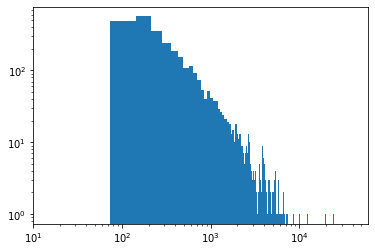

In [11]:

fig, ax = plt.subplots()
sizes = np.zeros(len(events_cleaned))
for i in range(len(events_cleaned)):
    sizes[i] = events_cleaned[i].size
ax.hist(sizes, bins = 800)
ax.set_xlim(left = 10)
ax.set_xscale("log")
ax.set_yscale("log")
plt.savefig("Density after cleaning.png")

001
002
003
004


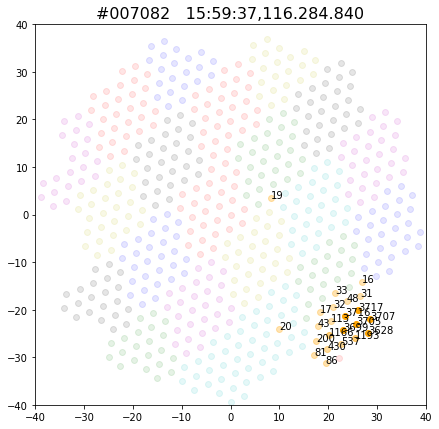

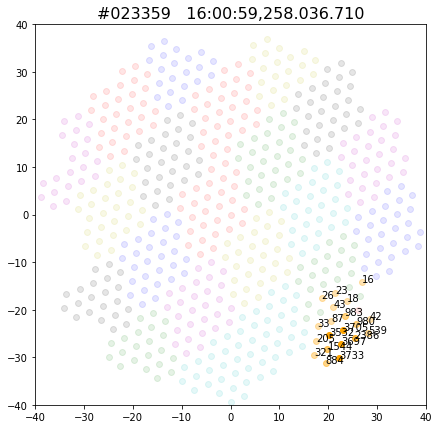

Error in callback <function flush_figures at 0x7f601f45d940> (for post_execute):


KeyboardInterrupt: 

In [48]:
events_cleaned = []
for nrun in range(1, 5):
    #events_cleaned += outs('{:03}'.format(nrun), peds = Peds(nrun))
    Nrun = '{:03}'.format(nrun)
    print(Nrun)
    peds = Peds(Nrun)
    o = outs(Nrun, peds)
    for e in o:
        if e.size > 20000:
            e.vizualize(pixel_coords = pixel_coords, save = True)
    events_cleaned += o
    


In [27]:
import pandas as pd
df = pd.read_csv("Params01.csv", sep = '\t')
df['Alpha'] = np.degrees(np.arcsin(df['Miss']/df['Dis']))
df.describe()

,Nrun,ID,Size,A,B,Width,Length,Dis,Miss,Alpha
count,93616.000000,9.361600e+04,93616.000000,93616.000000,93616.000000,93616.000000,93616.000000,93616.000000,93616.000000,93616.000000
mean,68.895616,1.202853e+06,715.344119,0.287600,-6.018797,1.404120,3.987788,22.870718,15.110847,46.636435
std,38.247940,5.407128e+05,1905.963945,91.501367,1585.760560,0.651787,2.480314,8.291659,9.702959,26.577825
min,1.000000,2.400000e+01,71.000000,-10744.875000,-237319.370000,0.000000,1.186000,0.028000,0.000000,0.000000
25%,37.000000,7.008158e+05,171.000000,-0.932000,-27.013500,1.045000,2.569000,16.912000,6.865000,23.293837
50%,69.000000,1.294416e+06,283.000000,0.103000,-3.587500,1.247000,3.311000,23.832000,14.076000,47.336200
75%,101.000000,1.693940e+06,561.250000,1.064000,18.613250,1.569000,4.505000,29.789000,22.480250,70.336390
max,138.000000,1.995440e+06,62968.000000,8123.898000,182164.965000,18.521000,32.400000,37.590000,37.146000,90.000000


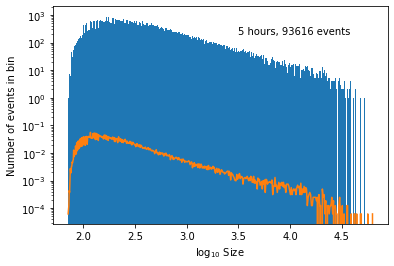

(500, 500)

In [28]:
fig, ax = plt.subplots()
#ax.set_xlim(left = 10)
#ax.set_xscale("log")
time = 4.5*60*60
x = np.log10(pd.Series(df['Size']))

hist, bins, _ = plt.hist(x, bins=500)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
logbins = np.delete(logbins, 1, 0)
plt.plot(logbins, hist/time)
#plt.xscale('log')
ax.set_yscale("log")
ax.set_xlabel(r'log$_{10}$ Size')
ax.set_ylabel("Number of events in bin")
ax.text(3.5, 200, "5 hours, "+ str(len(df))+" events")
#ax.hist(df['Size'], bins = 600)
plt.show()
len(logbins),len( hist)

In [12]:
events_cleaned[12918].vizualize(pixel_coords = pixel_coords, save = True)
events_cleaned[12918].params()

IndexError: list index out of range